# Plan
✅ 1. Skini podatke \
✅ 2. Izdvoji train i test\
✅ 3. Analiza train skupa\
✅ 4. Normalizacija/standardizacija\
✅ 5. Vizuelizacija\
✅ 6. Dodavanje suma

------
1. Par modela obicna, NN, MCS neki i base performanse - rez kao matrica + granice odlucivanja
2. Regularizacija modela + sve iz prvog koraka
3. Dim reduction + 1. korak
4. Otklanjanje outlier + 1. korak
5. Redukcija suma atributa + 1. korak
6. Otklanjanje suma labela + 1. korak
7. OvO vs OvA
8. Modeli otporni na sum
9. Autoencoder za denoising|

# Import

In [95]:
%pip install kagglehub openpyxl imbalanced-learn

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [96]:
import kagglehub as kg
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


# Load data

In [97]:
path = kg.dataset_download("muratkokludataset/dry-bean-dataset")
file_name = '/Dry_Bean_Dataset/Dry_Bean_Dataset.xlsx'
print("Downloaded at: ", path)

Downloaded at:  /Users/danilomilosevic/.cache/kagglehub/datasets/muratkokludataset/dry-bean-dataset/versions/1


In [98]:
data = pd.read_excel(path+file_name)

In [99]:
data

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


In [100]:
def get_onehot(class_count, class_ind):
    rez = np.zeros(class_count)
    rez[class_ind] = 1
    return rez

unique_vals = np.unique(data['Class'])
class_map_oh = {x: get_onehot(len(unique_vals), i) for i, x in enumerate(unique_vals)}
class_map_label = {x: i for i, x in enumerate(unique_vals)}

In [101]:
data['Class_OneHot'] = data['Class'].apply(lambda x: class_map_oh[x])
data['Class_Label'] = data['Class'].apply(lambda x: class_map_label[x])
data.drop(axis=1, labels=['Class'], inplace=True)

In [102]:
data

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class_OneHot,Class_Label
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",5
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",5
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",5
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",5
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",3
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",3
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",3
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",3


# Train/Test split

Odmah izdvajamo train i test set u razmeri 70:30

In [103]:
def plot_attributes(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 5, figsize=(20, 20))
    fig.suptitle("Histograms of Attributes", fontsize=10)

    axes = axes.flatten()

    for i, col in enumerate(df.columns):  
        if 'OneHot' in col:
            continue
        sns.histplot(df[col], bins= 7 if col == 'Class_Label' else 10, kde=True, ax=axes[i])
        axes[i].set_title(f'{col}')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_attr_label(df: pd.DataFrame, labels = None):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    fig.suptitle("Scatter Plots of Attributes vs Class_Label", fontsize=16)

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Loop through the first 16 features and plot scatter plots
    for i, col in enumerate(df.columns[:-2]):  
        sns.scatterplot(x=df[col], y= df['Class_Label'] if labels is None else labels, alpha=0.6, ax=axes[i])
        axes[i].set_title(f'{col}')

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
    plt.show()

In [104]:
train_perc = 0.6
test_perc = 1 - train_perc

In [105]:
split = StratifiedShuffleSplit(n_splits=1, test_size=test_perc, random_state=42)

# Perform the split
for train_idx, test_idx in split.split(data, data['Class_Label']):
    train_set = data.iloc[train_idx]
    test_set = data.iloc[test_idx]

print('Train size: ', len(train_set), 'x', len(train_set.iloc[0]))
print('Test size: ', len(test_set), 'x', len(test_set.iloc[0]))

Train size:  8166 x 18
Test size:  5445 x 18


# EDA

In [106]:
train_set

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class_OneHot,Class_Label
636,37179,704.496,240.383587,197.179245,1.219112,0.571978,37555,217.572455,0.771669,0.989988,0.941349,0.905105,0.006466,0.002677,0.819216,0.998716,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",5
9351,47446,835.604,321.134469,188.419866,1.704356,0.809781,47952,245.784710,0.678760,0.989448,0.853903,0.765364,0.006768,0.001433,0.585782,0.998381,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",6
3424,148931,1403.498,496.126875,382.826994,1.295956,0.636070,149919,435.459342,0.823961,0.993410,0.950104,0.877718,0.003331,0.001220,0.770388,0.998389,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1
4868,77107,1073.559,415.676982,237.312060,1.751605,0.821016,77867,313.329988,0.796017,0.990240,0.840721,0.753782,0.005391,0.001074,0.568188,0.995241,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",2
1144,39984,729.801,254.431815,200.581162,1.268473,0.615228,40353,225.630694,0.820892,0.990856,0.943381,0.886802,0.006363,0.002428,0.786418,0.997550,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,65806,1042.863,361.126192,234.700328,1.538669,0.760009,67326,289.459499,0.707470,0.977423,0.760363,0.801547,0.005488,0.001397,0.642477,0.988560,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
9569,48866,866.649,324.320728,192.771821,1.682407,0.804180,50022,249.435610,0.672493,0.976890,0.817580,0.769102,0.006637,0.001432,0.591517,0.995173,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",6
495,36340,683.845,235.806123,196.762148,1.198432,0.551124,36609,215.103522,0.803271,0.992652,0.976516,0.912205,0.006489,0.002772,0.832118,0.997237,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",5
8408,43068,779.010,286.960261,193.008429,1.486776,0.740010,43897,234.170623,0.775246,0.981115,0.891823,0.816039,0.006663,0.001823,0.665919,0.990072,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",6


In [107]:
train_set.describe()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class_Label
count,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000
mean,52936.493877,854.365557,319.797900,202.107847,1.582861,0.750955,53654.350478,252.830793,0.749340,0.987123,0.873396,0.799894,0.006568,0.001717,0.643610,0.995046,3.532941
std,29191.586185,213.293569,85.283671,44.881304,0.245585,0.091707,29629.939382,58.973329,0.049068,0.004702,0.059099,0.061475,0.001126,0.000595,0.098623,0.004445,1.828757
min,20420.000000,524.932000,183.601165,122.512653,1.036423,0.262774,20684.000000,161.243764,0.566768,0.943559,0.489618,0.640577,0.002778,0.000567,0.410339,0.949990,0.000000
25%,36209.250000,702.524000,253.025436,175.757874,1.434210,0.716830,36609.250000,214.716206,0.718445,0.985636,0.832788,0.762652,0.005914,0.001160,0.581639,0.993712,2.000000
50%,44672.000000,795.031000,297.260628,192.418646,1.551106,0.764435,45206.000000,238.491419,0.759160,0.988282,0.883294,0.801260,0.006647,0.001689,0.642017,0.996380,3.000000
75%,61235.000000,975.891000,375.666018,216.469268,1.705878,0.810160,62224.500000,279.225399,0.786509,0.990006,0.916556,0.833567,0.007273,0.002170,0.694834,0.997880,5.000000
max,248424.000000,1895.940000,726.373493,460.198497,2.430306,0.911423,251082.000000,562.408446,0.858420,0.994677,0.990685,0.981611,0.010451,0.003665,0.963560,0.999733,6.000000


Atributi 
- Area
- Perimeter
- Major Axis Length
- Minor Axis Length
- AspectRation
- ConvexArea
- EquivDiameter 

imaju dosta velike vrednosti dok ostali atributi su u range $[0-1]$

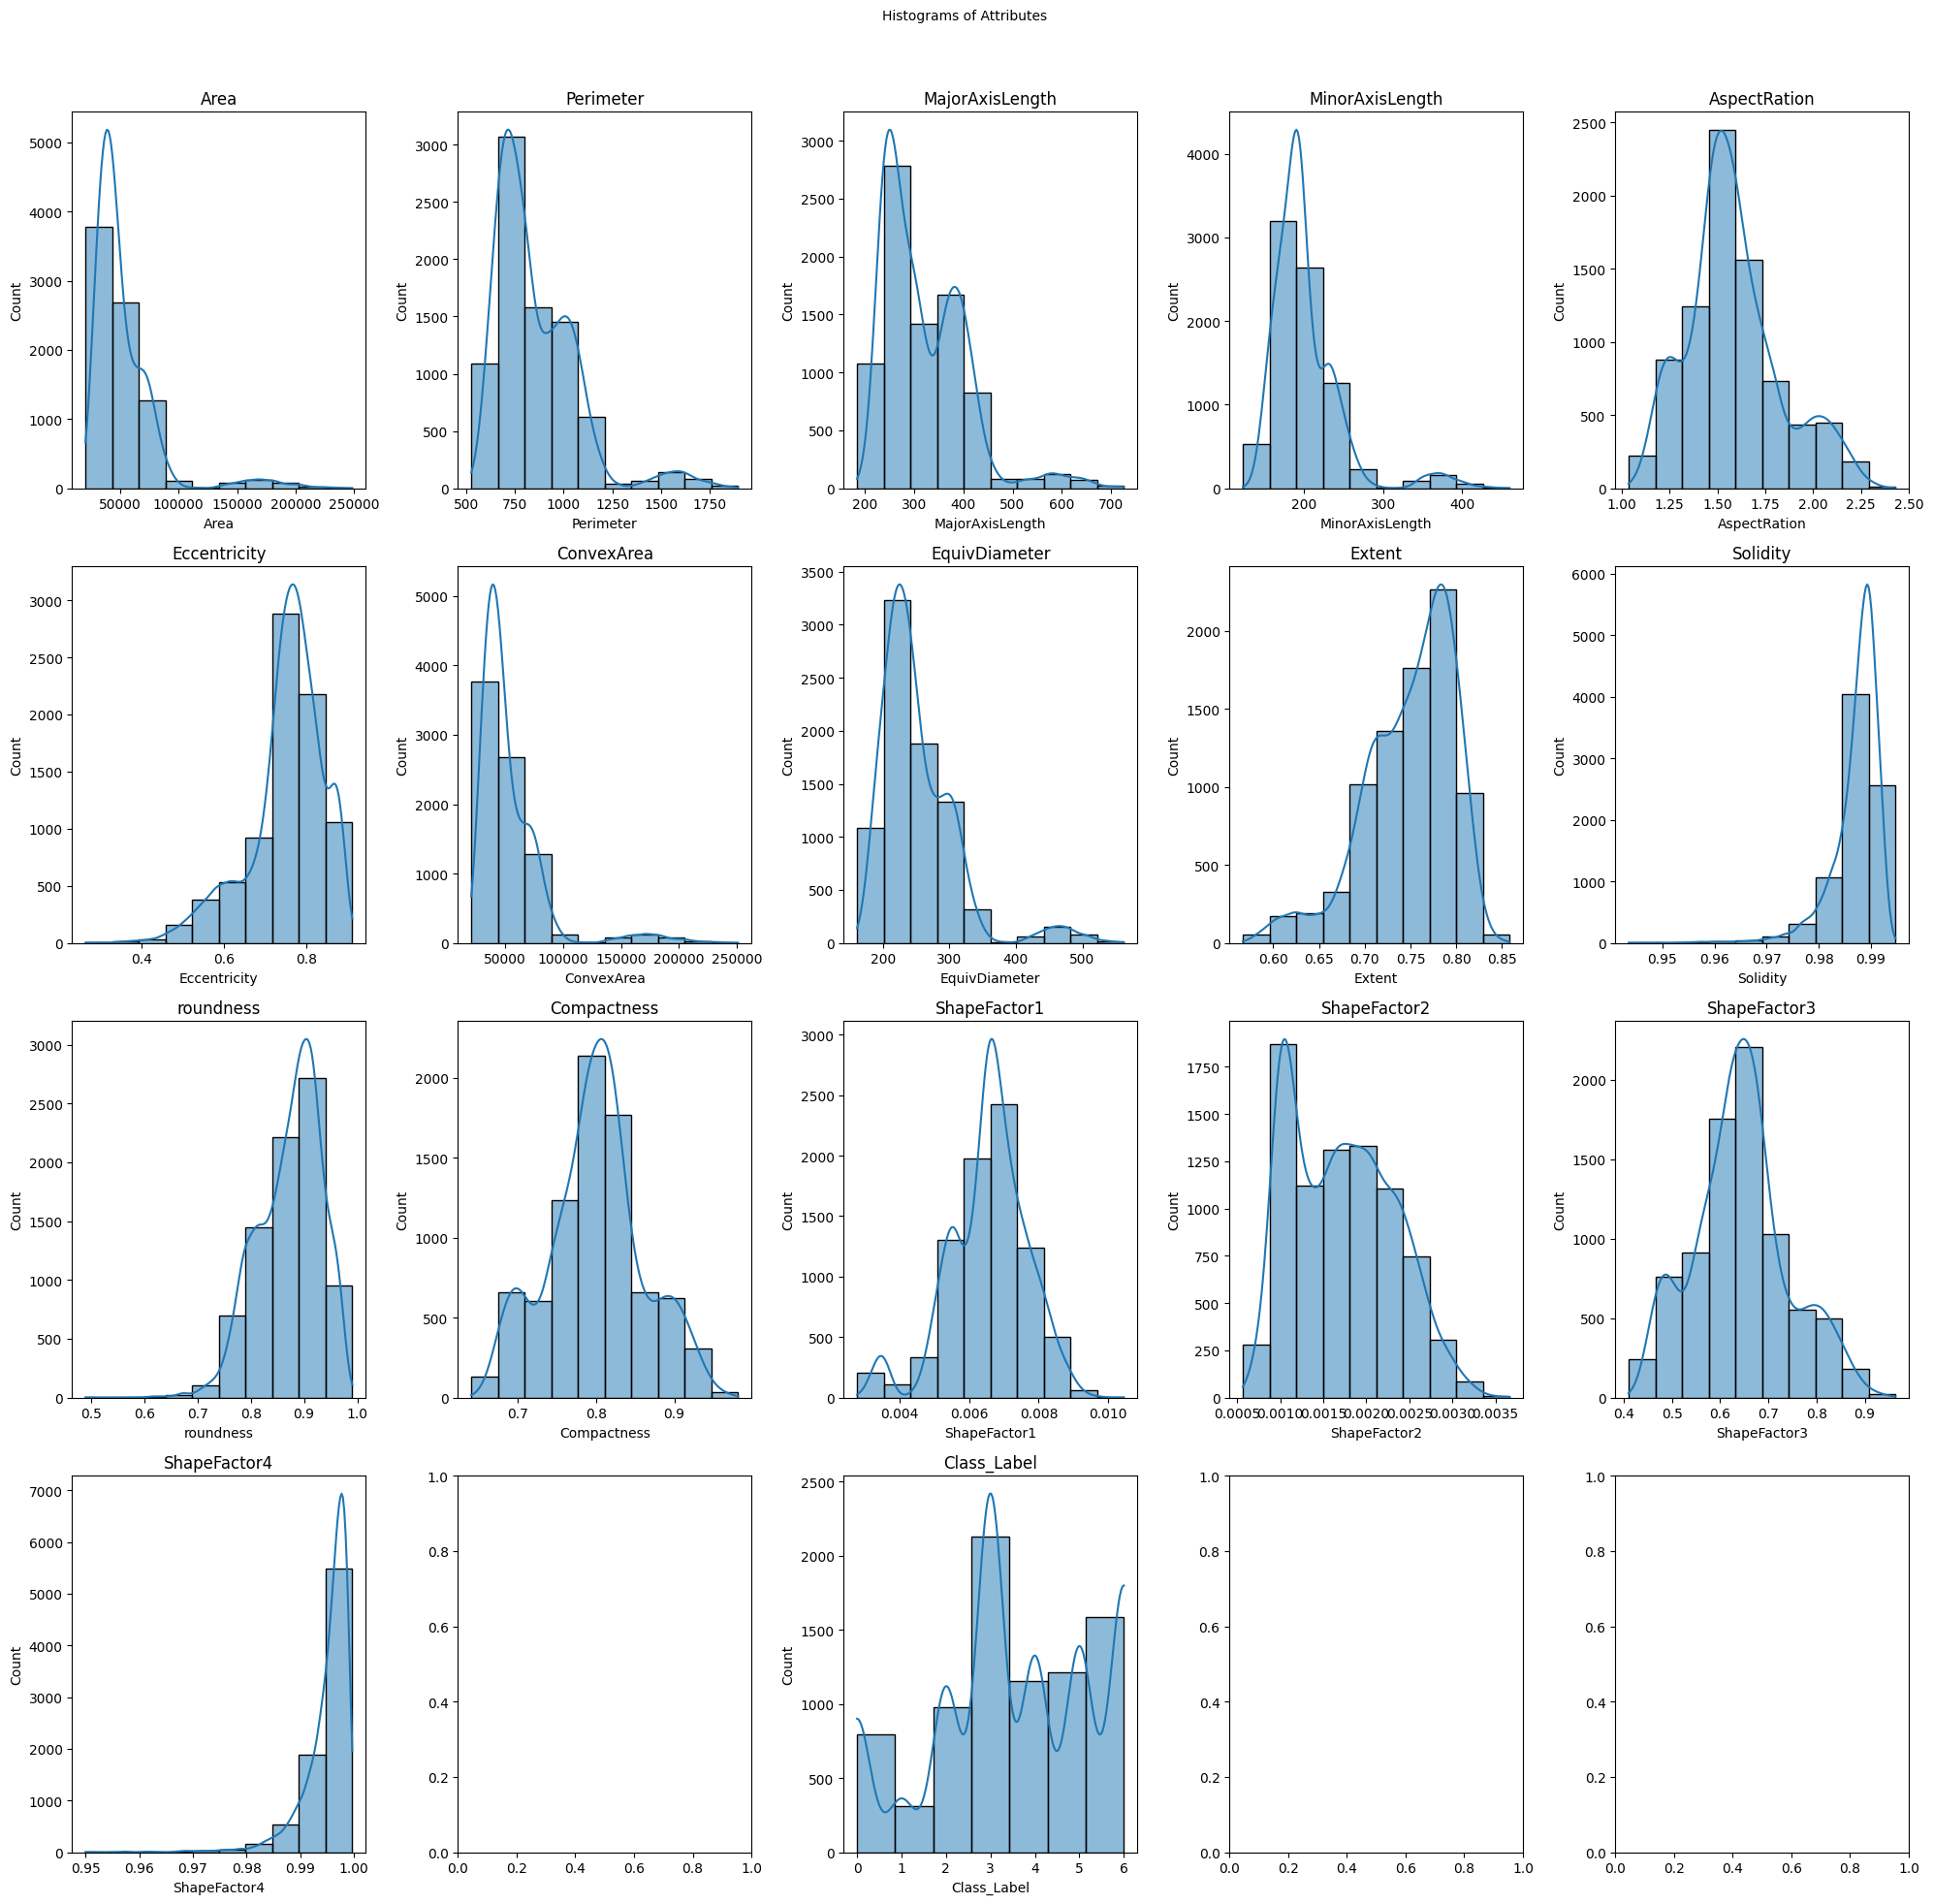

In [108]:
plot_attributes(train_set)

Sa grafikona vidimo da vrednosti atributa ne prate normalnu raspodelu.\
Atributi kao ShapeFactor4 i Solidity imaju velike repove. Zato ćemo tokom preprocesiranja normalizovati raspodele.\
Pored toga skup podataka nije balansiran:
- Klasa 1 je slabo zastupljena sa manje od 500 instanci, klasa 0 ima oko 1000 dok klasa 3 dominira sa oko 2500 instanci
- Zato ćemo izvršiti under i oversampling na oko 1-1.5 hiljade instanci

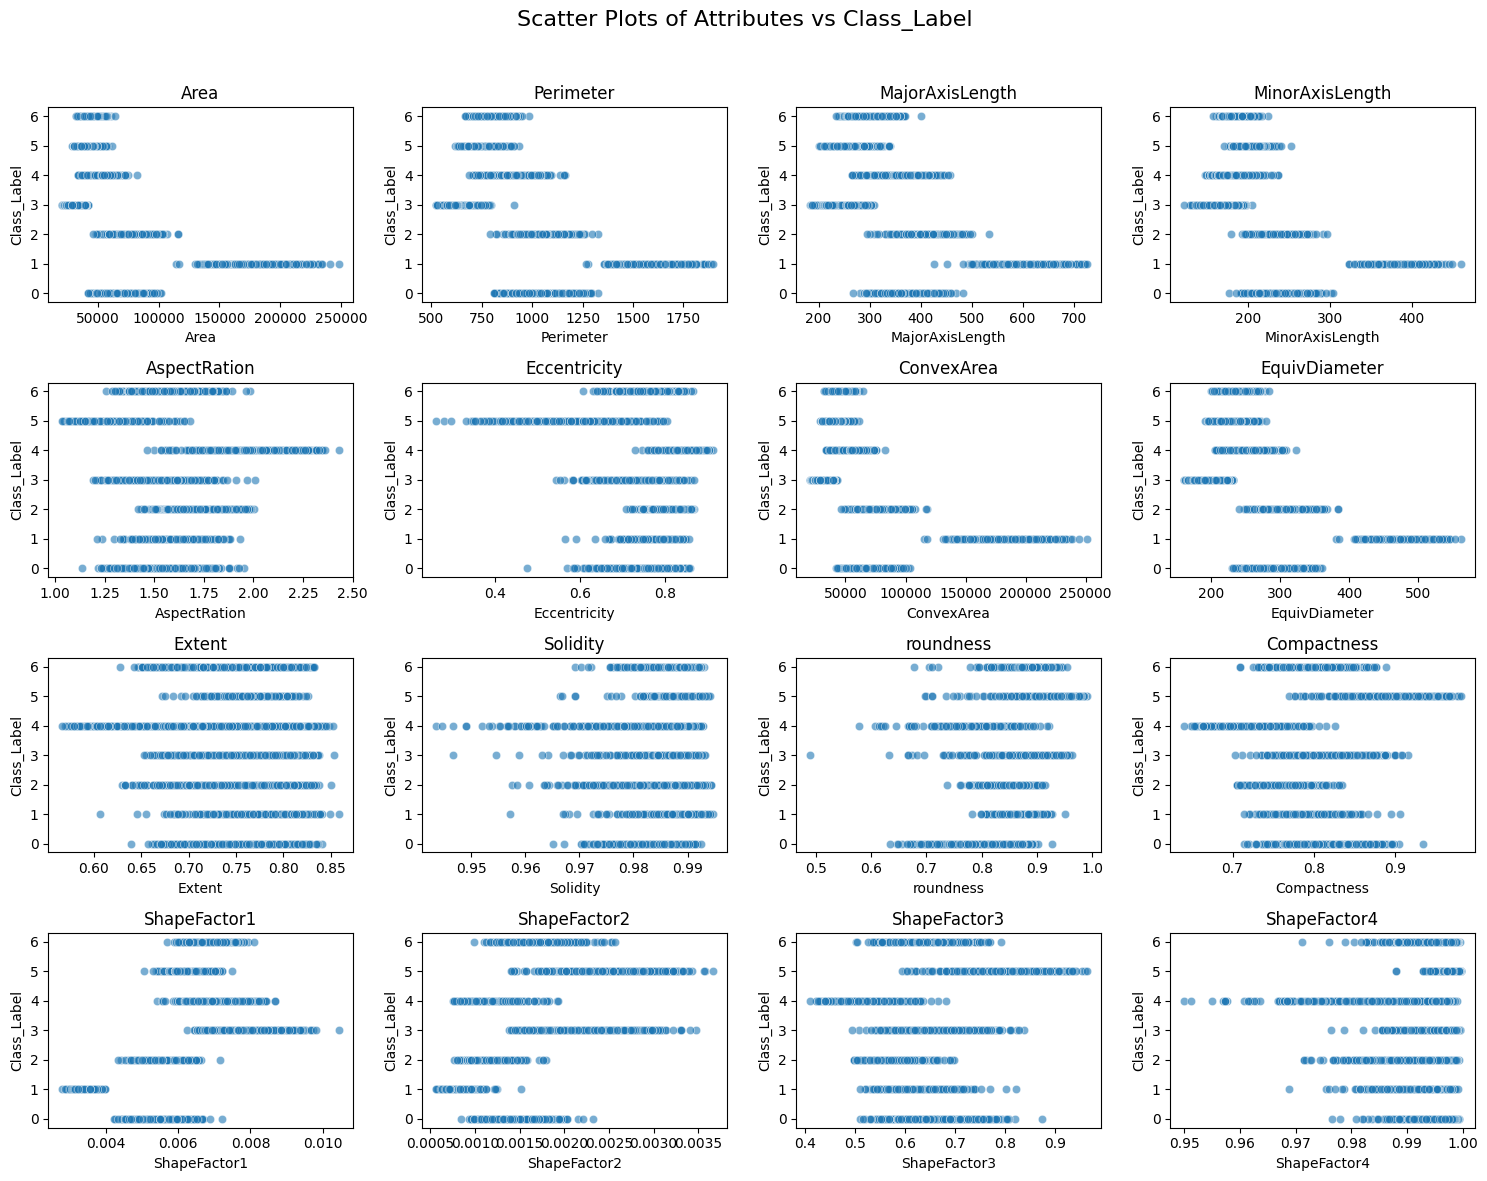

In [109]:
plot_attr_label(train_set)

Po grafikonu iznad vidimo da se klasa 1 karakteriše visokim vrednostima Major i Minor axis length, EquivDiameter, ConvexArea, Area i Perimeter. Pored toga ima male vrednosti ShapeFactor1.

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:600px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Podaci su nebalansirani, potrebno je under i over sample-ovati na oko 1-1.5 hiljade instanci</li>
<li>Atribute je potrebno normalizovati, a neke i skalirati kao što su Area</li>
<li>Klasa 1 je nedovoljno zastupljena ali lako prepoznatljiva po atributima koji imaju visoke vrednosti kao što je Area</li>
</ul>
</div>


# Normalizacija i Standardizacija

In [110]:
y_oh = train_set['Class_OneHot']
y_lab = train_set['Class_Label']
X = train_set.drop(axis = 1, labels=['Class_OneHot','Class_Label'])

In [111]:
pt = PowerTransformer(method='yeo-johnson')
X_pt = pt.fit_transform(X)

/Users/danilomilosevic/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [112]:
scaler = MinMaxScaler()
train_set_scaled = scaler.fit_transform(X_pt)
X_pt = pd.DataFrame(train_set_scaled, columns=X.columns)

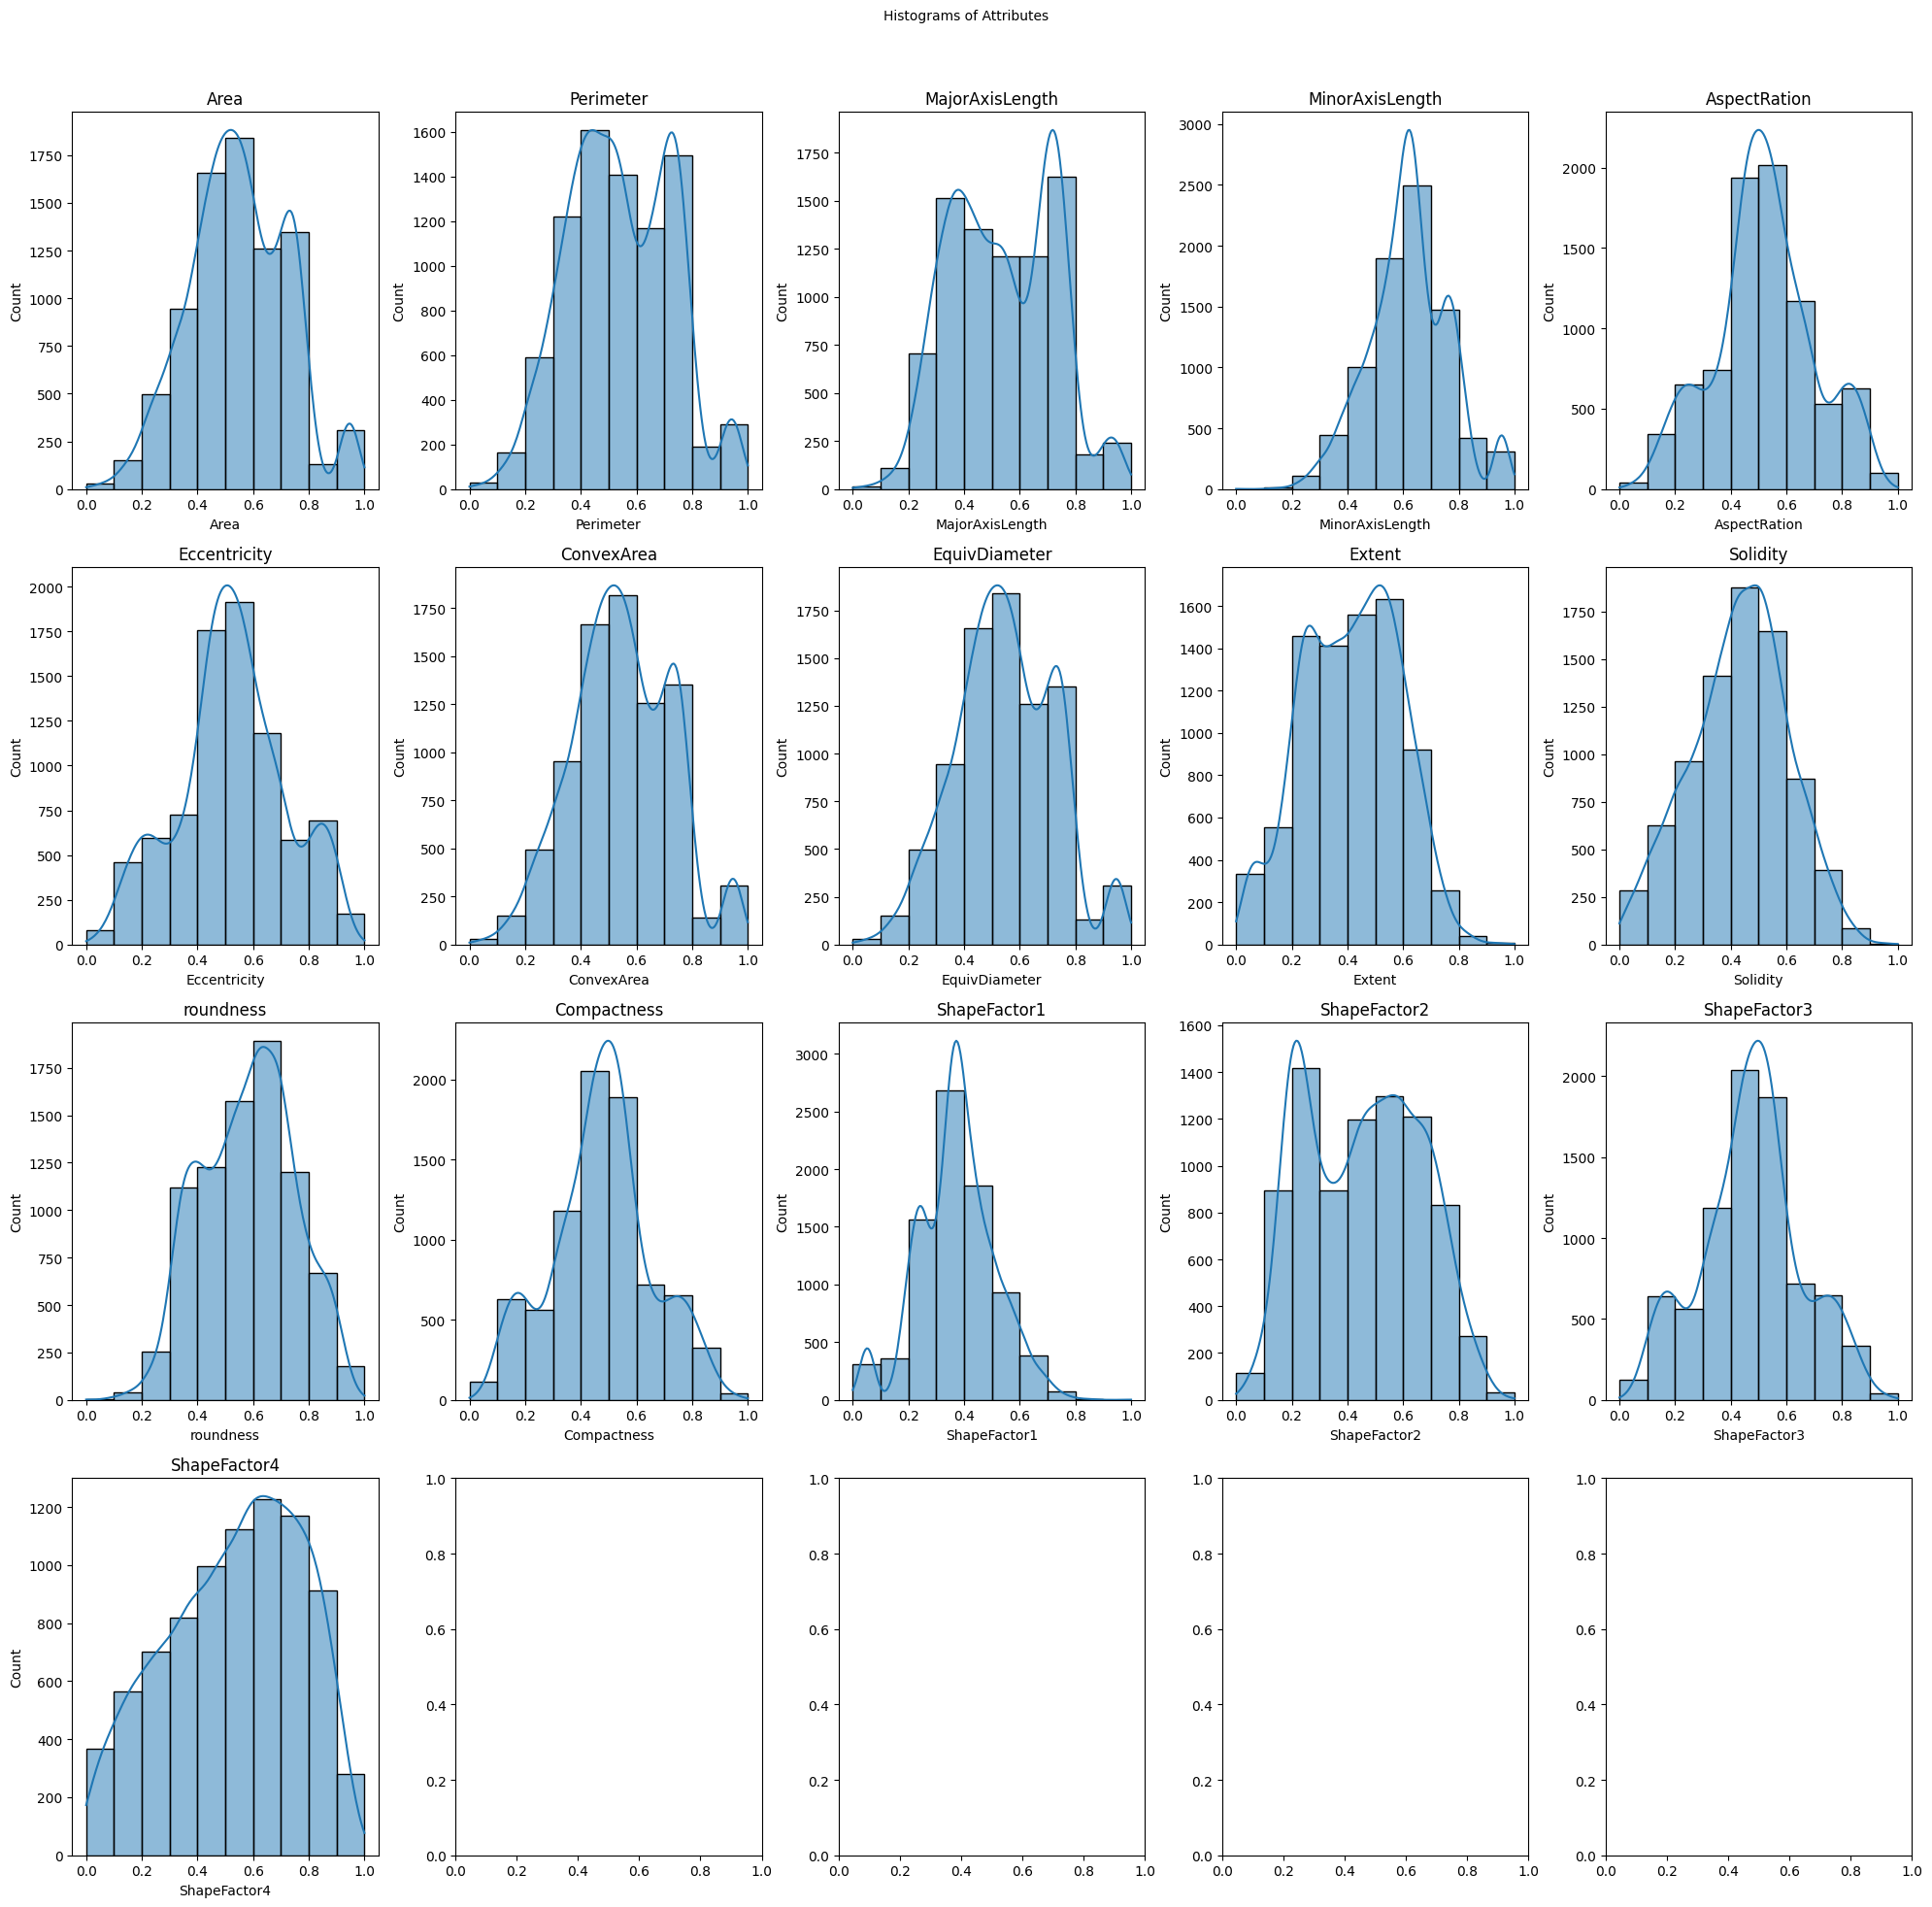

In [113]:
plot_attributes(X_pt)

Podaci sada prate raspodele dosta bliže normalnoj raspodeli

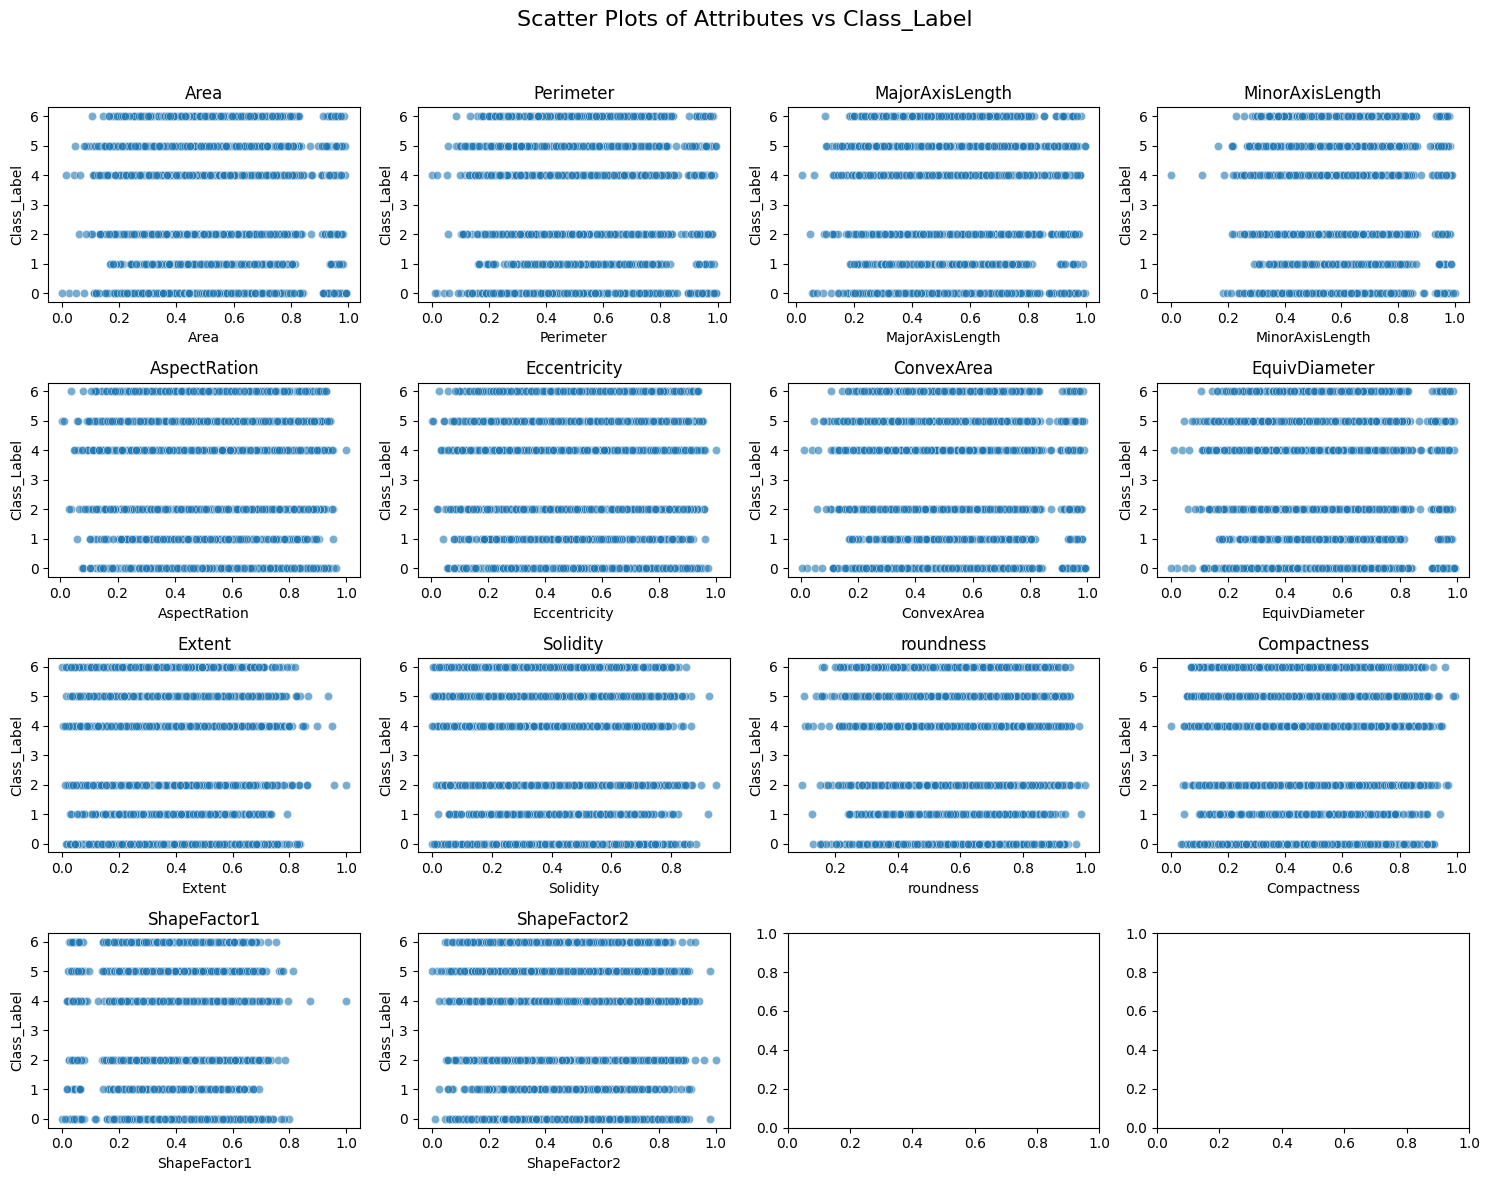

In [114]:
plot_attr_label(X_pt, labels=y_lab)

# Under/OverSampling

In [115]:
target_samples = 1000 # Pick a number in the range

# Oversample with SMOTE and undersample with RandomUnderSampler
smote = SMOTE(sampling_strategy=lambda y: {k: max(target_samples, v) for k, v in Counter(y).items() if v < target_samples}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pt, y_lab)

under = RandomUnderSampler(sampling_strategy=lambda y: {k: min(target_samples, v) for k, v in Counter(y).items() if v > target_samples}, random_state=42)
X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)

# Convert back to DataFrame
df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced['target'] = y_resampled

In [116]:
df_balanced['target_oh'] = df_balanced['target'].apply(lambda x: get_onehot(len(np.unique(df_balanced['target'])), x))

In [117]:
df_balanced

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,target,target_oh
24,0.710472,0.733553,0.631405,0.802877,0.349617,0.335774,0.713486,0.710506,0.329932,0.151921,0.341882,0.646020,0.199883,0.469594,0.646734,0.622736,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
30,0.743868,0.787663,0.740427,0.763075,0.633321,0.650754,0.746242,0.743918,0.433786,0.179808,0.232354,0.366437,0.237786,0.255040,0.364565,0.586257,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
39,0.782410,0.804788,0.726653,0.842263,0.430789,0.426800,0.783568,0.782478,0.767699,0.277340,0.313576,0.562794,0.163366,0.350248,0.562776,0.396798,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
57,0.772915,0.772547,0.746216,0.810895,0.546539,0.556254,0.773400,0.772979,0.510529,0.368883,0.458717,0.448458,0.193845,0.284592,0.447308,0.360082,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
61,0.678476,0.696889,0.646326,0.743739,0.498291,0.502589,0.683447,0.678493,0.643607,0.084420,0.379451,0.490592,0.260487,0.383811,0.489858,0.168564,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,0.545150,0.508876,0.484482,0.665031,0.380269,0.370028,0.543703,0.545095,0.618132,0.611466,0.753071,0.617696,0.328587,0.570246,0.618180,0.817878,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6021,0.517312,0.504726,0.507857,0.599950,0.506622,0.511896,0.518365,0.517243,0.318066,0.324184,0.608385,0.486182,0.394845,0.484961,0.485404,0.291479,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
4139,0.466617,0.467340,0.472141,0.545800,0.524924,0.532288,0.466150,0.466526,0.285966,0.461646,0.555884,0.470967,0.444292,0.501999,0.470037,0.435685,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1483,0.525825,0.515615,0.533127,0.585507,0.560934,0.572133,0.525187,0.525761,0.394485,0.492632,0.592017,0.435364,0.406702,0.441223,0.434090,0.419886,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


Sada imamo tačno 1250 instaci u svakoj klasi

<div style="background-color:#12AA12; height:auto; border-radius:10px; padding:16px; width:600px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Podaci su sada izbalansirani - svaka klasa ima 1250 instanci</li>
<li>Atribute su normalizovani i skalirani na 0-1</li>
</ul>
</div>

# Dodavanje šuma

In [118]:
def generate_random(x, noise_chance):
    "Returns x or a uniform random value. Noise_chance represents the chance of getting a random value"
    throw = np.random.rand()
    if throw < noise_chance:
        return np.random.rand()
    return x

def generate_gauss_random(x, noise_chance):
    "Returns x or a gaussian random value. Noise_chance represents the chance of getting a random value"
    throw = np.random.rand()
    if throw < noise_chance:
        return np.random.randn()
    return x

def add_attribute_noise(X: pd.DataFrame, noise_perc:float, class_labels, noise_gen = None):
    """noise_perc percentage of values will be replaced by a random value"""
    X_new = X.copy()
    for i, col in enumerate(X.columns):
        if col in class_labels:
            continue
        X_new[col] = X_new[col].apply(lambda x: generate_random(x, noise_perc) if noise_gen is None else noise_gen(x, noise_perc))
    return X

def get_random_class(y, noise_chance, classes):
    "Returns y or a random class. Noise_chance represents the chance of getting a random value"
    throw = np.random.rand()
    if throw < noise_chance:
        i = np.random.randint(0, len(classes))
        return classes[i] if classes[i]!=y else classes[(i+1)%len(classes)]
    return y

def add_class_noise(y:pd.DataFrame, noise_perc:float):
    "noise_perc percentage of labels will be randomly swapped with another label"
    y_new = y.copy()
    unique_classes = list(np.unique(y_new))
    y_new = y.apply(lambda x: get_random_class(x, noise_perc, unique_classes))
    return y_new

# Baseline performanse

- Par modela - y osa
- Par nivoa suma - x osa
- Matrica preciznosti
- Matrica gubitka preciznosti

Tako za sum labela i za sum atributa
Posle svake metode obrade podataka - isto ovo ponovi - najbolje da bude funkcija


In [152]:
def train_model_k_fold(model, k, X, y):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    scores = []
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)  # Train
        y_pred = model.predict(X_test)  # Predict
        acc = accuracy_score(y_test, y_pred)  # Evaluate
        scores.append(acc)
    return model, np.average(scores)

def train_models_with_noise(X, y, models, noise_schedule=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]):
    results = []
    acc_losses = []
    for model in models:
        result = []
        accuracy_loss = [0]
        for i, noise_level in enumerate(noise_schedule):
            X_n = add_attribute_noise(X, noise_level, [])
            _, acc = train_model_k_fold(model, 5, X_n, y)
            result.append(acc)
            if i > 0:
                accuracy_loss.append((acc - result[0])/result[0] * 100)
        results.append(result)
        acc_losses.append(accuracy_loss)
    return results, acc_losses


In [ ]:
X_t = df_balanced.drop(axis=1,labels=['target','target_oh'])
y = df_balanced['target']

In [143]:
X_t

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
24,0.710472,0.733553,0.631405,0.802877,0.349617,0.335774,0.713486,0.710506,0.329932,0.151921,0.341882,0.646020,0.199883,0.469594,0.646734,0.622736
30,0.743868,0.787663,0.740427,0.763075,0.633321,0.650754,0.746242,0.743918,0.433786,0.179808,0.232354,0.366437,0.237786,0.255040,0.364565,0.586257
39,0.782410,0.804788,0.726653,0.842263,0.430789,0.426800,0.783568,0.782478,0.767699,0.277340,0.313576,0.562794,0.163366,0.350248,0.562776,0.396798
57,0.772915,0.772547,0.746216,0.810895,0.546539,0.556254,0.773400,0.772979,0.510529,0.368883,0.458717,0.448458,0.193845,0.284592,0.447308,0.360082
61,0.678476,0.696889,0.646326,0.743739,0.498291,0.502589,0.683447,0.678493,0.643607,0.084420,0.379451,0.490592,0.260487,0.383811,0.489858,0.168564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,0.545150,0.508876,0.484482,0.665031,0.380269,0.370028,0.543703,0.545095,0.618132,0.611466,0.753071,0.617696,0.328587,0.570246,0.618180,0.817878
6021,0.517312,0.504726,0.507857,0.599950,0.506622,0.511896,0.518365,0.517243,0.318066,0.324184,0.608385,0.486182,0.394845,0.484961,0.485404,0.291479
4139,0.466617,0.467340,0.472141,0.545800,0.524924,0.532288,0.466150,0.466526,0.285966,0.461646,0.555884,0.470967,0.444292,0.501999,0.470037,0.435685
1483,0.525825,0.515615,0.533127,0.585507,0.560934,0.572133,0.525187,0.525761,0.394485,0.492632,0.592017,0.435364,0.406702,0.441223,0.434090,0.419886


In [144]:
rfc = RandomForestClassifier(max_depth=2)
svc = SVC(kernel='linear', C=100)

In [153]:
train_models_with_noise(X_t, y, [rfc,svc])

([[np.float64(0.7042857142857143),
   np.float64(0.6912857142857143),
   np.float64(0.7155714285714285),
   np.float64(0.7035714285714286),
   np.float64(0.6890000000000001),
   np.float64(0.7062857142857142),
   np.float64(0.7362857142857143)],
  [np.float64(0.9397142857142857),
   np.float64(0.9397142857142857),
   np.float64(0.9397142857142857),
   np.float64(0.9397142857142857),
   np.float64(0.9397142857142857),
   np.float64(0.9397142857142857),
   np.float64(0.9397142857142857)]],
 [[0,
   np.float64(-1.8458417849898596),
   np.float64(1.6024340770791),
   np.float64(-0.10141987829613938),
   np.float64(-2.1703853955375183),
   np.float64(0.2839756592291934),
   np.float64(4.543610547667347)],
  [0,
   np.float64(0.0),
   np.float64(0.0),
   np.float64(0.0),
   np.float64(0.0),
   np.float64(0.0),
   np.float64(0.0)]])